## **Credit card fraud dection** 



## Table of Contents
- [Objectives](#Objectives)
- [Data-Preparation](#Data-Preparation)
- [Scenario](#Scenario)
- [Model-Building](#Model-Building)
- [Evaluation](#Evaluation)
- [Model-Improvement](#Model-Improvment)
- [Conclusion](#Conclusion)


# Objectives

Using exploring more advanced (ensemble) models to detect credit card fraud.

Exploring:
- Random Forest
- Gradient Boosting
- Isolation Forests



# Data-Preparation

### Importing Required Libraries

Libraries required for this notebook will be imported here

In [8]:
import pandas as pd

### Load in data

Data used: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [9]:
data = pd.read_csv("..\data\kaggel_credit_card_fraud_detection\creditcard.csv")
data.head(1)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0


### Split data into training and testing set

In [10]:
from sklearn.model_selection import train_test_split
X = data.drop(columns=["Class"])
y = data["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   
X_train.shape, X_test.shape, y_train.shape, y_test.shape  

((227845, 30), (56962, 30), (227845,), (56962,))

In [11]:
#check amounts of fraud and non-fraud
y_train.value_counts(), y_test.value_counts()

(Class
 0    227451
 1       394
 Name: count, dtype: int64,
 Class
 0    56864
 1       98
 Name: count, dtype: int64)

### Standardise data

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Scenario

Predict credit card fraud various ML models, creating, testing and validating them

### Data Description ###

The dataset used for this visualization project contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. Features V1-V28 have been deduced by PCA, and have names omitted due to confidentiality

The dataset includes the following variables:
<br>1. Time: Seconds elapsed between each transaction and the first transaction in the dataset.
<br>2-29. V1 - V28: Anonymised features deduced by PCA
<br>30. Amount: transaction Amount, this feature can be used for example-dependant cost-sensitive learning
<br>31. Class: Responce varialbe for fraud classification (0 = not fraud, 1 = fraud)




# Model-Building

## Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=10,
    oob_score=True,
    random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)



C:\Users\aiden\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


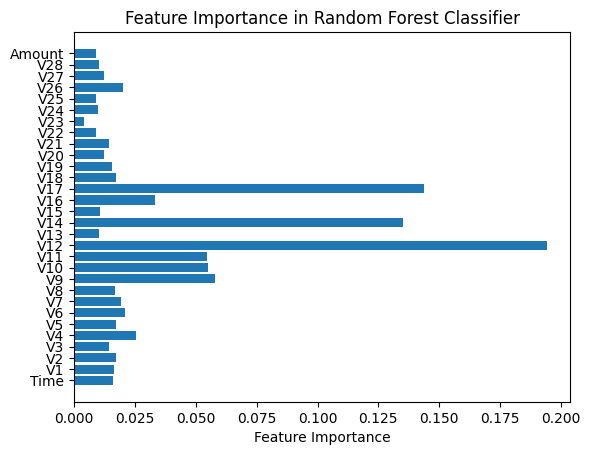

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
feature_importances = rf.feature_importances_

plt.barh(X.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()

# Evaluation

Accuracy: 99.96%


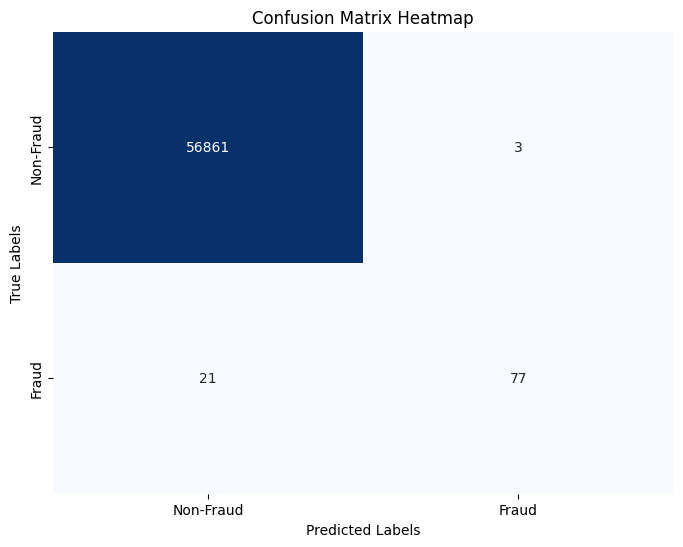

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, 
           xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [16]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud'])
print(report)
print("OOB Score:", rf.oob_score_)

              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.96      0.79      0.87        98

    accuracy                           1.00     56962
   macro avg       0.98      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962

OOB Score: 0.9993943250894248


Great accuracy on detecting non-fraud, needs tuning to better detect fraud.

**Model improvement** 

Basicl model works better but can be improved. GridSearch will be used to tune model hyperparameters.

In [17]:
param_grid = {
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                            scoring='accuracy', cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)



Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters found:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5}
Best cross-validation score:  0.9995084376188776


C:\Users\aiden\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [18]:
# Use the best estimator from grid search
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)
y_pred_best = best_rf.predict(X_test)

print("OOB Score after tuning: ", grid_search.best_estimator_.oob_score_)
report = classification_report(y_test, y_pred_best, target_names=['Non-Fraud', 'Fraud'])
print(report)
print("OOB Score:", best_rf.oob_score_)

C:\Users\aiden\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


OOB Score after tuning:  0.9993943250894248
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.96      0.80      0.87        98

    accuracy                           1.00     56962
   macro avg       0.98      0.90      0.94     56962
weighted avg       1.00      1.00      1.00     56962

OOB Score: 0.9993943250894248


Accuracy: 99.96%


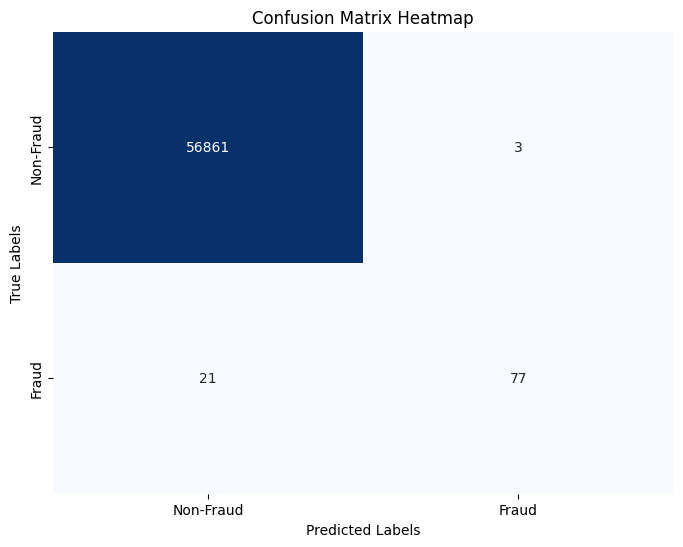

In [19]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, 
           xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Model-Improvement

No improvement in fraud detection despite extensive hyperparameter optimisation. The focus should be on improving recall on fraud case with the following:
 - Class weighting: Put a greater emphasis on the fraud class
 - Feature importance analysis: Bias more predictive features and/or drop noisy features
 - SMOTE or ADASYN: Synthetic oversampling to help boost recall for the fraud class
 - Threshold tuning: Adjust the decision threshold to improve sensitivity to fraud
 - Cost-sensitive evaluation: Evaluate with metrics like precision-recall AUC 